In this notebook we provide the code to generate the figures depicting the characteristics of our AGBD dataset: climatic space and biome-level AGBD distribution. This notebook reproduces Fig.2 from the main text. 

In [2]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt

Read the trainig dataset and the ecoregions polygon layer storing informatino on biomes' spatial distribution. Add biome information to the training dataset.

In [8]:
from data import fetch_ecoregion_data

training_dataset = pd.read_csv("./data/training/agbd_climate_training_dataset_spatialkfolds_1000km.csv")
biomes_filename = fetch_ecoregion_data()

from geoutils import add_feature

training_dataset = gpd.GeoDataFrame(
        training_dataset,
        geometry= gpd.points_from_xy(x=training_dataset.lon, y=training_dataset.lat)
    )
training_dataset.crs = "EPSG:4326"

training_dataset = add_feature(training_dataset,"BIOME_NAME",biomes_filename,"Biome")

Plot the climatic conditions of the positive AGBD instances within the training dataset. Climatic space is represented in 2 dimensions: the annual mean daily temperature and the annual precipitation amount. 

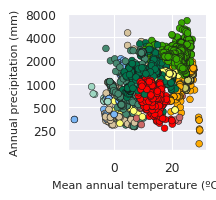

In [9]:
# Retrieve color codes for the biomes from the ecoregions layer.
biomes = gpd.read_file(biomes_filename)
bio_color = biomes.groupby(by="BIOME_NAME").agg({"COLOR_BIO":"first"})
bio_color = bio_color.drop(index="N/A")

# Set an order for the biomes.
order= [
     "Tropical & Subtropical Moist Broadleaf Forests",
     "Tropical & Subtropical Dry Broadleaf Forests",
     "Tropical & Subtropical Grasslands, Savannas & Shrublands",
     "Tropical & Subtropical Coniferous Forests",
     "Mangroves",
     "Flooded Grasslands & Savannas",
     "Temperate Broadleaf & Mixed Forests", 
     "Temperate Conifer Forests",
     "Temperate Grasslands, Savannas & Shrublands",
     "Mediterranean Forests, Woodlands & Scrub",
     "Deserts & Xeric Shrublands",
     "Boreal Forests/Taiga",
     "Tundra",
     "Montane Grasslands & Shrublands"
    ]  

# Associate the right color to each biome, preserving the color code from the ecoregions layer.
bio_color = bio_color.reindex(order).reset_index()
palette = sns.color_palette( palette = bio_color["COLOR_BIO"], desat=1.0)

# Function to shorten biome names to help visualization.
def shorten_biome_names(names):
     match names:
          case "Tropical & Subtropical Moist Broadleaf Forests":
               return "Tropical moist"
          case "Tropical & Subtropical Dry Broadleaf Forests":
               return "Tropical dry"
          case "Tropical & Subtropical Grasslands, Savannas & Shrublands":
               return "Tropical savannas"
          case "Tropical & Subtropical Coniferous Forests":
               return "Tropical coniferous"
          case "Mangroves":
               return "Mangroves"
          case "Flooded Grasslands & Savannas":
               return "Flooded savannas"
          case "Temperate Broadleaf & Mixed Forests":
               return "Temperate broadleaf"
          case "Temperate Conifer Forests":
               return "Temperate coniferous"
          case "Temperate Grasslands, Savannas & Shrublands":
               return "Temperate savannas"
          case "Mediterranean Forests, Woodlands & Scrub":
               return "Mediterranean forests"
          case "Deserts & Xeric Shrublands":
               return "Deserts"
          case "Boreal Forests/Taiga":
               return "Boreal forests"
          case "Tundra":
               return "Tundra"
          case "Montane Grasslands & Shrublands":
               return "Montane grasslands"            
training_dataset["bio_short"] = training_dataset["Biome"].apply(lambda name: shorten_biome_names(name))

# Re-establish a biome order for the short names.
order_short = [
        "Tropical moist",
        "Tropical dry",
        "Tropical savannas",
        "Tropical coniferous",
        "Mangroves",
        "Flooded savannas",
        "Temperate broadleaf", 
        "Temperate coniferous",
        "Temperate savannas",
        "Mediterranean forests",
        "Deserts",
        "Boreal forests",
        "Tundra",
        "Montane grasslands"
    ]  

sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})
sns.set_style("darkgrid")

# Filter out 0 AGBD instances.
df = training_dataset[training_dataset["agbd"]>0]

g1 = sns.relplot(
    data=df,
    x="bio1", # Annual maean daily temperature.
    y="bio12", # Annual precipitation amount.
    hue="bio_short",
    edgecolor="0.1",
    height = 2.,
    aspect = 1.1,
    hue_order = order_short,
    palette=palette,
    alpha=1.0,
    legend=False
)
g1.set(yscale="log")
g1.set(yticks=[250,500,1000,2000,4000,8000],yticklabels=[250,500,1000,2000,4000,8000])
g1.set(ylabel='Annual precipitation (mm)')
g1.set(xlabel='Mean annual temperature (ºC)')
plt.savefig("./figures/training_dataset_climatic_space_300dpi.png",dpi=300)
plt.savefig("./figures/training_dataset_climatic_space.svg")



Plot biome-level distributions of AGBD.

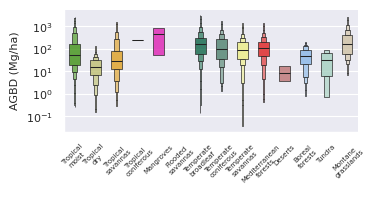

In [10]:
import textwrap

sns.set_context("paper", rc={"font.size":8,"axes.titlesize":6,"axes.labelsize":8,"xtick.labelsize":5,"ytick.labelsize":8})

g = sns.catplot(
    data=df,x="bio_short",y="agbd",
    kind="boxen",
    hue="bio_short",
    legend=False,
    aspect=2.2,height=1.8,
    palette=palette, width_method = "exponential", k_depth="trustworthy", width=.5, showfliers=False,
    hue_order = order_short,
    order= order_short,
    alpha=0.8
)

g.set(ylabel="AGBD (Mg/ha)")
g.set(xlabel="")
g.set_xticklabels(rotation=45)
g.set(yscale="log")
labels = [textwrap.fill(label.get_text(), 10, break_long_words = False) for label in g.axes[0][0].get_xticklabels()]
g.set_xticklabels(labels)
plt.savefig("./figures/training_dataset_agbd_distribution_300dpi.png",dpi=300,bbox_inches = "tight")
plt.savefig("./figures/training_dataset_agbd_distribution.svg",bbox_inches = "tight")

Count the number of instances for each biome.

In [11]:
df["bio_short"].value_counts()

bio_short
Tropical moist           995
Temperate broadleaf      798
Mediterranean forests    260
Temperate savannas       248
Tropical dry             233
Temperate coniferous     227
Tropical savannas        153
Boreal forests           151
Montane grasslands       150
Tundra                    16
Deserts                    9
Mangroves                  4
Tropical coniferous        1
Name: count, dtype: int64

Export the training dataset in shapefile format to plot the spatial coverage with a GIS software (we used QGIS).

In [30]:
training_dataset.to_file("./data/training/agbd_climate_training_dataset_spatialkfolds_1000km.shp",driver="ESRI Shapefile")

Index(['cluster', 'bio3', 'bio15', 'bio1', 'bio2', 'bio7', 'bio12', 'gsl',
       'bio4', 'bio8', 'bio5', 'bio10', 'bio11', 'bio19', 'bio9', 'bio13',
       'bio16', 'bio18', 'bio14', 'bio17', 'bio6', 'lat', 'lon', 'td_mean',
       'td_std', 'agbd', 'mean_abd', 'std_abd', 'score', 'bw', 'fold_1000km',
       'geometry', 'Biome', 'bio_short'],
      dtype='object')


/tmp/ipykernel_1110218/73847342.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  training_dataset.to_file("./data/training/agbd_climate_training_dataset_spatialkfolds_1000km.shp",driver="ESRI Shapefile")
